# DeepXDE - Bernard Cavity - Transient case

In this notebook i'll be implementing the bernard cavity case. I'll be following the paper Hashemi+2024 and adding some twists to make it work better as i go.

In [1]:
import deepxde as dde
import torch
import numpy as np

import matplotlib.pyplot as plt



# dde.config.set_default_float("float64")

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [53]:
rho = 1
mu = 0.001
alpha = 0.005
D = 0.1
L = D
beta = 1.0
g = 9.81

T0 = 300
T_bottom = 301

S0 = (T0 - T0)/(T_bottom - T0)
S_bottom = (T_bottom - T0)/(T_bottom - T0)


assert T_bottom > T0, "For a Benard cell the bottom temperature should be higher than the rest"

Ra = g*beta*(T_bottom-T0)*D**3*rho/(alpha*mu)
Pr = mu/(rho*alpha)
print(f"{Ra = }, {Pr = }")

Ra = 1962.0000000000005, Pr = 0.2


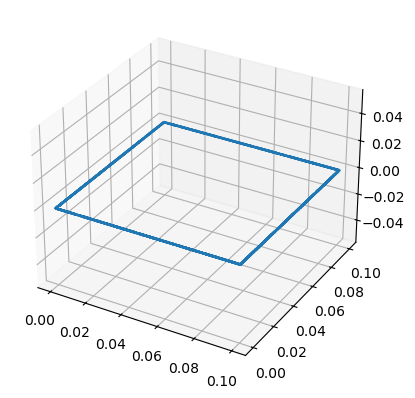

In [54]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


x, y, t = geomtime.random_boundary_points(10000).T

plt.scatter(y, x, t)

In [88]:
# Define geometry

## Let's go with a square for this case
geom = dde.geometry.Rectangle(xmin=(0, 0), xmax=(1., 1.))

## Adding time domain
timedomain = dde.geometry.TimeDomain(0, 1.0)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)


# Define boundaries and boundary conditions
def boundary_top(X,on_boundary):
    on = np.logical_and(dde.utils.isclose(X[1], D),on_boundary)
    return on

def boundary_bottom(X,on_boundary):
    on = np.logical_and(dde.utils.isclose(X[1], 0),on_boundary)
    return on

def boundary_sides(X,on_boundary):
    on = ~boundary_bottom(X, on_boundary) and ~boundary_top(X, on_boundary) and on_boundary
    return on

def boundary_walls(X,on_boundary):
    return on_boundary


## Here we will have 2 dirichlet conditions on the speed components and one in the pressure 
bc_wall_u = dde.DirichletBC(geomtime, lambda x: 0, boundary_walls, component=0)
bc_wall_v = dde.DirichletBC(geomtime, lambda x: 0, boundary_walls, component=1)

bc_top_T    = dde.DirichletBC(geomtime, lambda x: S0      , boundary_top, component=3)
bc_bottom_T = dde.DirichletBC(geomtime, lambda x: S_bottom, boundary_bottom, component=3)
bc_sides_T  = dde.NeumannBC(geomtime,   lambda x: 0       , boundary_sides, component=3)

ic_u = dde.icbc.IC(geomtime,lambda x: 0, lambda _, on_initial: on_initial ,component=0)
ic_v = dde.icbc.IC(geomtime,lambda x: 0, lambda _, on_initial: on_initial ,component=1)
ic_T = dde.icbc.IC(geomtime,lambda x: (S0+S_bottom)/2, lambda _, on_initial: on_initial ,component=3)

def pde_nondimensional(X,Y):
    """Nondimensional Boussinesq approximated NS equations"""
    
    du_x = dde.grad.jacobian(Y, X, i=0, j=0)
    du_y = dde.grad.jacobian(Y, X, i=0, j=1)
    du_t = dde.grad.jacobian(Y, X, i=0, j=2)
    
    dv_x = dde.grad.jacobian(Y, X, i=1, j=0)
    dv_y = dde.grad.jacobian(Y, X, i=1, j=1)
    dv_t = dde.grad.jacobian(Y, X, i=1, j=2)
    
    dp_x = dde.grad.jacobian(Y, X, i=2, j=0)
    dp_y = dde.grad.jacobian(Y, X, i=2, j=1)

    
    du_xx = dde.grad.hessian(Y, X, component=0, i=0, j=0)
    du_yy = dde.grad.hessian(Y, X, component=0, i=1, j=1)
    dv_xx = dde.grad.hessian(Y, X, component=1, i=0, j=0)
    dv_yy = dde.grad.hessian(Y, X, component=1, i=1, j=1)
    
    dT_x = dde.grad.jacobian(Y, X, i=3, j=0)
    dT_y = dde.grad.jacobian(Y, X, i=3, j=1)
    dT_t = dde.grad.jacobian(Y, X, i=3, j=2)
    
    dT_xx = dde.grad.hessian(Y, X, component=3, i=0, j=0)
    dT_yy = dde.grad.hessian(Y, X, component=3, i=1, j=1)

    pde_cont   = du_x + dv_y
    pde_u      = du_t + Y[:,0:1]*du_x +  Y[:,1:2]*du_y + dp_x - (Pr/Ra)**0.5*(du_xx+ du_yy)
    pde_v      = dv_t + Y[:,0:1]*dv_x +  Y[:,1:2]*dv_y + dp_y - (Pr/Ra)**0.5*(dv_xx+ dv_yy) - Y[:, 3:]
    pde_energy = dT_t + Y[:,0:1]*dT_x +  Y[:,1:2]*dT_y - (dT_xx + dT_yy)/(Pr*Ra)**0.5

    return [pde_u, pde_v, pde_cont, pde_energy]

def non_dimensionalise_input(X):
    return X/D

def transform(X, Y):
    """Ansatz to make the spped exactly zero on the boundaries"""
    noslip_ansatz_factor = X[:, 0:1] * (L - X[:, 0:1]) * X[:, 1:2] * (D - X[:, 1:2])
    temperature_ansatz = X[:, 1:2]/D*(S0 + (D - X[:, 1:2])) + S_bottom * (D - X[:, 1:2])/D

    return torch.hstack(
        (
            noslip_ansatz_factor*Y[:, 0:2],  
            1.0 + (X[:, 0:1]**2 + X[:, 1:2]**2)**0.5*Y[:, 2:3],
            temperature_ansatz +  X[:, 1:2] * (D - X[:, 1:2])*Y[:, 3:]
        )
    )



# Define model

net = dde.maps.FNN([3,] + [512]*6 + [4,], "silu", "Glorot uniform")

HARD_NOSLIP = True

if HARD_NOSLIP:
    bcs = [bc_sides_T, ic_u, ic_v, ic_T]
    net.apply_output_transform(transform)
else:
    bcs = [bc_wall_u, bc_wall_v, bc_top_T, bc_bottom_T, bc_sides_T]


data = dde.data.TimePDE(
    geomtime,
    pde_nondimensional,
    bcs,
    num_domain=4*1024,
    num_boundary=4*256,
    num_initial=512,
    num_test=4*100
)

model = dde.Model(data, net)

In [84]:
class ReferencePointResampler(dde.callbacks.PDEPointResampler):
    def __init__(self, period, ref_point, **kwargs):
        super().__init__(period, bc_points=True, **kwargs)
        self.ref_point = ref_point

    
    def on_train_begin(self):
        """Add the desired reference point in the beginning of the trainining"""
        super().on_train_begin()
        bc_points = self.model.data.train_x_bc
        self.model.data.train_x_bc = np.vstack([bc_points, self.ref_point])
        

    def on_epoch_end(self):
        """
        Modification of parent method that add the reference point 
        after each resample if boundary points are being resampled.
        """

        self.epochs_since_last_resample = self.period

        act = self.epochs_since_last_resample == self.period
        
        super().on_epoch_end()
        
        # Append the reference point to BC points
        if self.bc_points and act:
            bc_points = self.model.data.train_x_bc
            self.model.data.train_x_bc = np.vstack([bc_points, self.ref_point])




In [85]:
# resampler = ReferencePointResampler(period=100, ref_point=np.array([0, 0]))
resampler = dde.callbacks.PDEPointResampler(period=100)

checkpointer = dde.callbacks.ModelCheckpoint(
    filepath="model.ckpt",  # prefix and path for saved model files
    verbose=1,                           # print saving messages
    save_better_only=True,              # save every period or only if improved
    period=5_000,                       # save every epoch; set to e.g. 10 to save every 10 epochs
    monitor="train loss"                # metric to monitor, "train loss" or "test loss"
)

In [89]:
# Train model

#1st stage - ADAM optimizer
adam = torch.optim.Adam(net.parameters(), lr=0.001, betas=[0.9, 0.999])

model.compile(optimizer=adam)
losshistory_1, train_state_1 = model.train(iterations=97_000, callbacks=[resampler, checkpointer])

# 2nd stage - L-BFGS optimizer 
model.compile("L-BFGS")
dde.optimizers.config.set_LBFGS_options(ftol=1e-12, gtol=1e-12)
losshistory_2, train_state_2 = model.train(iterations=3_000, callbacks=[resampler, checkpointer])

Compiling model...
'compile' took 0.000048 s

Training model...

0         [1.77e-07, 3.65e-01, 7.36e-15, 1.02e+00, 6.62e-15, 1.70e-20, 2.15e-21, 8.33e-02][1.76e-07, 3.01e-01, 3.69e-15, 1.02e+00, 6.62e-15, 1.70e-20, 2.15e-21, 8.33e-02][]  
1000      [6.02e-04, 1.68e-03, 1.42e-05, 5.14e-05, 1.77e-05, 7.39e-09, 5.51e-09, 8.30e-02][4.09e-04, 8.28e-05, 6.25e-06, 1.21e-05, 1.77e-05, 7.39e-09, 5.51e-09, 8.30e-02][]  
2000      [9.29e-05, 5.94e-04, 7.07e-06, 1.07e-05, 1.49e-06, 2.90e-09, 3.39e-09, 8.30e-02][2.32e-06, 1.38e-05, 3.01e-06, 5.67e-06, 1.49e-06, 2.90e-09, 3.39e-09, 8.30e-02][]  
3000      [2.50e-04, 1.35e-03, 9.11e-06, 1.11e-05, 7.45e-07, 3.22e-09, 4.97e-09, 8.30e-02][1.91e-05, 1.18e-05, 3.93e-06, 3.41e-06, 7.45e-07, 3.22e-09, 4.97e-09, 8.30e-02][]  
4000      [1.78e-04, 5.61e-04, 1.21e-06, 1.08e-05, 2.55e-06, 2.77e-10, 7.10e-10, 8.30e-02][2.96e-05, 6.50e-05, 4.34e-07, 5.20e-06, 2.55e-06, 2.77e-10, 7.10e-10, 8.30e-02][]  
5000      [4.18e-05, 3.30e-04, 1.11e-07, 6.66e-06, 1.68e-06,

In [ ]:
# model.restore("path/to/model.ckpt-xxx", verbose=1)

In [101]:
np.hstack([samples, np.ones(shape=(samples.shape[0], 1))*0.5])

array([[0.        , 0.        , 0.5       ],
       [0.        , 0.00322581, 0.5       ],
       [0.        , 0.00645161, 0.5       ],
       ...,
       [0.1       , 0.09354839, 0.5       ],
       [0.1       , 0.0967742 , 0.5       ],
       [0.1       , 0.1       , 0.5       ]])

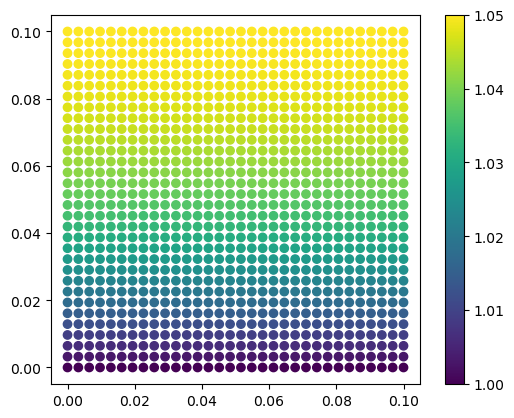

In [106]:
samples = geom.uniform_points(1000)

samples_t = np.hstack([samples, np.ones(shape=(samples.shape[0], 1))*1])


res = model.predict(samples_t) 

x, y  = samples.T
u, v, p, T = res.T

plt.scatter(x, y, c=p)
plt.colorbar()

plt.gca().set_aspect("equal")

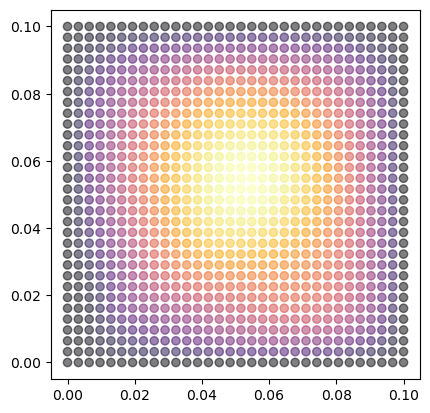

In [107]:

V = np.sqrt(v**2 + u**2)
plt.scatter(x, y, c=v, alpha=0.5, cmap="inferno")

plt.gca().set_aspect("equal")

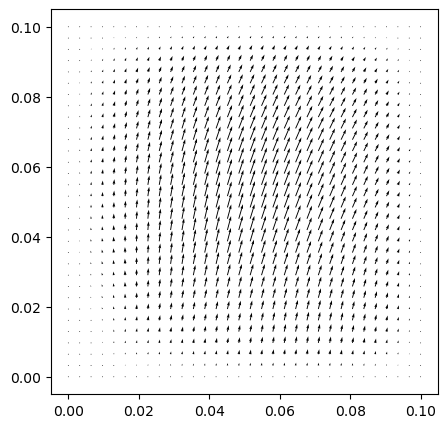

In [108]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.quiver(x, y, u, v)
# plt.gca().set_aspect("equal")

In [110]:
# samples = geom.random_boundary_points(1000)
# res = model.predict(samples)

# x, y = samples.T
# u, v, p, T = res.T

# V = np.sqrt(v**2 + u**2)
# plt.scatter(x, y, c=v, alpha=0.8)

# plt.colorbar()
# plt.gca().set_aspect("equal")

In [111]:
# samples = geom.random_boundary_points(1000)
# res = model.predict(samples)

# x, y = samples.T
# u, v, p, T = res.T

# plt.scatter(x, y, c=p, alpha=0.8)

# plt.colorbar()

# plt.gca().set_aspect("equal")